#Pre-run
Loading the necessery libraries.

In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import os
import string 
from google.colab import drive
from string import punctuation
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
import time
import matplotlib.pyplot as plt


mounting the drive and checking for device






In [2]:
drive.mount('/content/drive')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('training on: ',device)


Mounted at /content/drive
training on:  cuda


## Loading the data (text) files from the drive.
loading the train data.


In [3]:
with open('/content/drive/Shared drives/ex2_208298349_211538608/datasets/PTB/train/ptb.train.txt', 'r') as f:
  train_txt = f.read()
with open('/content/drive/Shared drives/ex2_208298349_211538608/datasets/PTB/train/ptb.char.train.txt', 'r') as f:
  train_char = f.read()

Loading the validation data.



In [ ]:
with open('/content/drive/Shared drives/ex2_208298349_211538608/datasets/PTB/valid/ptb.valid.txt', 'r') as f:
  val_txt = f.read()
with open('/content/drive/Shared drives/ex2_208298349_211538608/datasets/PTB/valid/ptb.char.valid.txt', 'r') as f:
  val_char = f.read()

Loading the test data.


In [ ]:
with open('/content/drive/Shared drives/ex2_208298349_211538608/datasets/PTB/test/ptb.test.txt', 'r') as f:
  test_txt = f.read()
with open('/content/drive/Shared drives/ex2_208298349_211538608/datasets/PTB/test/ptb.char.test.txt', 'r') as f:
  test_char = f.read()

#Creating the text data and its correct predictions

Cleans the text from any "bad" words or usless chars like punctuatuions.

In [ ]:
def clean_txt(txt):
  return txt.replace("\n","<eos>") # a string of the words

Creates the dictionoary that maps the word to a number

In [ ]:
def create_mapping(original):
  data = clean_txt(original)
  # data = original.split()
  data = [word for word in data.split()]
  counts = Counter(data)
  vocab = sorted(counts, key=counts.get, reverse=True)
  mapping = {word:i for i,word in enumerate(vocab, 0)} 
  return mapping

creating the text list of the train, validation, test data.

In [ ]:
mapping = create_mapping(train_txt)
anamoly_mapping = len(mapping)
#if the word is known from the training set we give it the appropiate value, otherwise set it to a anomaly value
train_t = [mapping[word] if word in mapping else anamoly_mapping for word in clean_txt(train_txt).split()]
test_t = [mapping[word] if word in mapping else anamoly_mapping for word in clean_txt(test_txt).split()]
valid_t = [mapping[word] if word in mapping else anamoly_mapping for word in clean_txt(val_txt).split()]
number2word = {number: word for word, number in mapping.items()}

Creating the text list of the correct predictions - we just "indent" the words by one index and then (in the last word) loop around.

In [ ]:
train_pred = train_t[1:] + [train_t[0]]
test_pred = test_t[1:] + [test_t[0]]
valid_pred = valid_t[1:] + [valid_t[0]]


##Creating the loaders for our data - if needed

In [ ]:
def split_data_to_seqs(data: list, seq_length):
  sequences_amount = len(data) // seq_length
  # print(f'length of data: {len(data)} sequences amount: {sequences_amount} ')
  data = data[:(sequences_amount)*seq_length] #truncating the last not complete seq
  # print(f'length of new data: {len(data)}')  
  data_arr = np.array(data)
  data_arr = data_arr.reshape((sequences_amount, seq_length))

  print(data_arr.shape)
  return data_arr

In [ ]:
def split_batches(data_on_seqs: np.array, preds_on_seqs, batch_size=20):
  # print(data_on_seqs.shape)
  perms = np.random.permutation(data_on_seqs.shape[0])
  np.take(data_on_seqs, perms, axis=0, out=data_on_seqs)
  np.take(preds_on_seqs, perms, axis=0, out=preds_on_seqs)

  # print(data_on_seqs.shape)
#   arr = torch.LongTensor(data)

  for n in range(0, data_on_seqs.shape[0], batch_size):
    x = torch.LongTensor(data_on_seqs[n: n + batch_size, :]) # [batch_size, seq_length]
    y = torch.LongTensor(preds_on_seqs[n: n + batch_size, :]) # [batch_size, seq_length]
    yield x, y

In [ ]:
train_data = split_data_to_seqs(train_t, 20)
valid_data = split_data_to_seqs(valid_t, 20)
test_data = split_data_to_seqs(test_t, 20)

train_pred_data = split_data_to_seqs(train_pred, 20)
valid_pred_data = split_data_to_seqs(valid_pred, 20)
test_pred_data = split_data_to_seqs(test_pred, 20)


(46479, 20)
(3688, 20)
(4121, 20)
(46479, 20)
(3688, 20)
(4121, 20)


In [ ]:
seq_length = 20
train_seqs = split_data_to_seqs(train_t, seq_length)

# create Tensor datasets
train_data_temp = TensorDataset(torch.from_numpy(train_seqs),
                           torch.from_numpy(split_data_to_seqs(train_pred, seq_length)))
valid_data_temp = TensorDataset(torch.from_numpy(split_data_to_seqs(valid_t, seq_length)),
                           torch.from_numpy(split_data_to_seqs(valid_pred, seq_length)))
test_data_temp = TensorDataset(torch.from_numpy(split_data_to_seqs(test_t, seq_length)),
                          torch.from_numpy(split_data_to_seqs(test_pred, seq_length)))

# dataloaders
batch_size = 20

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data_temp, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data_temp, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data_temp, shuffle=True, batch_size=batch_size)

(46479, 20)
(46479, 20)
(3688, 20)
(3688, 20)
(4121, 20)
(4121, 20)


##Fixed Hyper Parametrs

In [ ]:
#hyper paramaters
batch_size = 20
seq_length = 20
# learning_rate = 1
vocab_size = len(mapping) + 1 #for the anamoly word
embedding_size = 200
# num_epochs = 13
num_layers = 2
# factor = 1.5


##We split data to batches

In [ ]:
def get_batches(data, batch_size, seq_length):
  arr = torch.LongTensor(data)
  batch_size_total = batch_size * seq_length
  n_batches = len(arr)//batch_size_total
  arr = arr[:n_batches * batch_size_total]
  # Reshape into batch_size rows
  arr = arr.reshape((batch_size, -1))
  for n in range(0, arr.shape[1], seq_length):
    x = arr[:, n:n+seq_length]
    y = torch.zeros_like(x)
    try:
      y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
    except IndexError:
      y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
    yield x, y


#Defining the model

In [ ]:
class Model(nn.Module):
  def __init__(self, mode = 'LSTM', with_drop = True, vocab_size = 10001, embedding_size = 200, 
               hidden_size = 200, n_layers = 2, drop = 0.5, batch_size = 20, seq_length=20):
    super(Model, self).__init__()

    self.mode = mode
    self.with_drop = with_drop
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.n_layers = n_layers
    self.drop = drop
    self.batch_size = batch_size
    self.embedding = nn.Embedding(vocab_size, embedding_size)
    self.vocab_size = vocab_size
    self.seq_length = seq_length

    if mode == 'LSTM':
      if with_drop == True:
        self.rnn = nn.LSTM(embedding_size, hidden_size, n_layers,
                           dropout = drop, batch_first=True)
        self.dropout = nn.Dropout(drop)
      else:
        self.rnn = nn.LSTM(embedding_size, hidden_size, n_layers, batch_first=True)
    
    else:
      if with_drop == True:
        self.rnn = nn.GRU(embedding_size, hidden_size, n_layers,
                          dropout = drop, batch_first=True)
        self.dropout = nn.Dropout(drop)
      else:
        self.rnn = nn.GRU(embedding_size, hidden_size, n_layers, batch_first=True)

    for name in self.embedding.named_parameters():
      if 'weight' in name[0]:
        torch.nn.init.uniform_(name[1], a=-0.1, b=0.1)

    self.classifier = nn.Linear(hidden_size, vocab_size)
    for name in self.classifier.named_parameters():
      if 'weight' in name[0]:
        torch.nn.init.uniform_(name[1], a=-0.1, b=0.1)
      elif 'bias' in name[0]:
        torch.nn.init.zeros_(name[1])
    

  def forward(self, x, hidden):
    x = self.embedding(x)
    if self.with_drop == True:
      x = self.dropout(x)#_before(x)
    out, hidden = self.rnn(x, hidden)
    out = out.contiguous().view(-1, self.hidden_size)
    if self.with_drop == True:
      out = self.dropout(out)#_after(out)
    out = self.classifier(out)
    out = out.view(self.batch_size, self.seq_length, -1)

    return out, hidden

  def init_hidden(self):
    '''In GRU we only carry on a hidden state and not a tuple of (hidden, c)'''
    weight = next(self.parameters()).data
    if self.mode == 'LSTM':
      if device == 'cuda':
          hidden = (weight.new(self.n_layers, self.batch_size, self.hidden_size).zero_().cuda(),
                weight.new(self.n_layers, self.batch_size, self.hidden_size).zero_().cuda())
      else:
          hidden = (weight.new(self.n_layers, self.batch_size, self.hidden_size).zero_(),
                    weight.new(self.n_layers, self.batch_size, self.hidden_size).zero_())
    else:
      if device == 'cuda':
          hidden = weight.new(self.n_layers, self.batch_size, self.hidden_size).zero_().cuda()
      else:
          hidden = weight.new(self.n_layers, self.batch_size, self.hidden_size).zero_()
    return hidden


#Training the model

This code cell was taken from: https://discuss.pytorch.org/t/adaptive-learning-rate/320/2

In [ ]:
def adjust_learning_rate(optimizer, epoch, max_epochs, factor=2, shrink_every=2, shrink_since = 6):
    """we start the *reduce by factor of 2 only after a 1/3 of the epochs have passed*"""
    if epoch >= shrink_since and epoch % shrink_every == 0: # if max = 13 than we will get that only for epochs 5 and up (13//3 = 4) we will decrease
      for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * (1/factor)


##Training using "get_batches"

In [ ]:
def train_model(model, criterion, optimizer, num_layers, batch_size,
                train_t, valid_t, num_epochs = 20, clip = 5, factor=2, shrink_every=1, shrink_since=4, seq_length=20, supress_output = False):
  
  if model.with_drop == False:
    num_epochs = 13
  train_perp = []
  val_perp = []
  for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch+1, num_epochs, factor, shrink_every, shrink_since) ##THIS FUNCTION REDUCES THE LR BY A FACTOR OF 2 EACH EPOCH 
    begin = time.time()
    train_losses = []
    model.train()
    hidden = model.init_hidden()#.to(device)#initiation
    for inputs, preds in get_batches(train_t,batch_size,seq_length):
      if inputs.shape[0] < batch_size:
        break #we reached the final batch and it doesn't fit
      inputs, preds = inputs.to(device), preds.to(device)

      if model.mode == "LSTM":
        hidden = tuple([each.data for each in hidden]) 
      elif model.mode == "GRU":
        hidden = hidden.data # it's not a tuple so we don't create a tuple.
        
      optimizer.zero_grad()
      output, hidden = model(inputs, hidden)
      loss = criterion(torch.transpose(output,1,2), preds)
      loss.backward()
      train_losses.append(loss.item())

      nn.utils.clip_grad_norm_(model.parameters(), clip) 
      optimizer.step()  

    # final eval after the full epoch
    val_hidden = model.init_hidden()#.to(device)
    val_losses = []
    model.eval()
    with torch.no_grad():
      for inputs, preds in get_batches(valid_t,batch_size,seq_length):
        if inputs.shape[0] < batch_size:
          break #we reached the final batch and it doesn't fit
        inputs, preds = inputs.to(device), preds.to(device)
        if model.mode == "LSTM":
          val_hidden = tuple([each.data for each in val_hidden]) 
        elif model.mode == "GRU":
          val_hidden = val_hidden.data

        output, val_hidden = model(inputs, val_hidden)
        val_loss = criterion(torch.transpose(output,1,2), preds)    
        val_losses.append(val_loss.item())
   
    train_loss_with_mean = torch.mean(torch.FloatTensor(train_losses)) 
    val_loss_with_mean = torch.mean(torch.FloatTensor(val_losses))
    train_perp.append(torch.exp(train_loss_with_mean))
    val_perp.append(torch.exp(val_loss_with_mean))
    if supress_output == False:
      print("Epoch: {}/{}...".format(epoch+1, num_epochs),
            "Train Perplexity: {:.4f}...".format(train_perp[epoch]),
            "Validation Perplexity: {:.4f}...".format(val_perp[epoch]))
      print('time per epoch: ', time.time()-begin)
  return model, train_perp, val_perp

##Training using our randomization

In [ ]:
def train_model_with_random(model, criterion, optimizer, num_layers, batch_size,
                train_data, valid_data, train_pred_data, valid_pred_data,
                 num_epochs = 20, clip = 2.5, factor=2, shrink_every=2, shrink_since=6, seq_length=20):
  
  if model.with_drop == False:
    num_epochs = 13
  train_perp = []
  val_perp = []
  for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch+1, num_epochs, factor, shrink_every, shrink_since) ##THIS FUNCTION REDUCES THE LR BY A FACTOR OF 2 EACH EPOCH 

    begin = time.time()
    counter = 0
    train_losses = []
    model.train()
    hidden = model.init_hidden()#.to(device)#initiation
    for inputs, preds in split_batches(train_data, train_pred_data, batch_size):
      if inputs.shape[0] < batch_size:
        # print(f'TRAIN SMALLER BATCH, INPUT: {inputs.shape} PREDS: {preds.shape}')
        break #we reached the final batch and it doesn't fit
      inputs, preds = inputs.to(device), preds.to(device)
      # print("val: ", inputs.shape)
      if model.mode == "LSTM":
        hidden = tuple([each.data for each in hidden]) 
      elif model.mode == "GRU":
        hidden = hidden.data # it's not a tuple so we don't create a tuple.
      optimizer.zero_grad()
      output, hidden = model(inputs, hidden)
      # print(f'output: {output.shape}, pred: {preds.shape}')
      # fit_output = torch.transpose(output,1,2)
      #first switch between the seq and the porb guess, second is switch between the seq and the batch 
      # print(f'fit output: {fit_output.shape}, pred: {preds.shape}')
      loss = criterion(torch.transpose(output,1,2), preds)
      loss.backward()
      train_losses.append(loss.item())

      nn.utils.clip_grad_norm_(model.parameters(), clip) 
      optimizer.step()  
      # counter += 1

    # final eval after the full epoch
    val_hidden = model.init_hidden()#.to(device)
    val_losses = []
    val_counter = 0
    model.eval()
    with torch.no_grad():
      for inputs, preds in split_batches(valid_data, valid_pred_data, batch_size):
        if inputs.shape[0] < batch_size:
          # print(f'VALIDATION SMALLER BATCH, INPUT: {inputs.shape} PREDS: {preds.shape}')
          break #we reached the final batch and it doesn't fit
        inputs, preds = inputs.to(device), preds.to(device)
        if model.mode == "LSTM":
          val_hidden = tuple([each.data for each in val_hidden]) 
        elif model.mode == "GRU":
          val_hidden = val_hidden.data

        output, val_hidden = model(inputs, val_hidden)
        val_loss = criterion(torch.transpose(output,1,2), preds)    
        val_losses.append(val_loss.item())
        # val_counter +=1
    # model.train()
    # train_loss = torch.sum(torch.FloatTensor(train_losses))/counter
    train_loss_with_mean = torch.mean(torch.FloatTensor(train_losses)) 
    # val_loss = torch.sum(torch.FloatTensor(val_losses))/val_counter
    val_loss_with_mean = torch.mean(torch.FloatTensor(val_losses))
    train_perp.append(torch.exp(train_loss_with_mean))
    val_perp.append(torch.exp(val_loss_with_mean))
    print("Epoch: {}/{}...".format(epoch+1, num_epochs),
            "Train Perplexity: {:.4f}...".format(train_perp[epoch]),
            "Validation Perplexity: {:.4f}...".format(val_perp[epoch]))
    print('time per epoch: ', time.time()-begin)
  return model, train_perp, val_perp  

##Training using the loaders

In [ ]:
def train_model_with_loaders(model, criterion, optimizer, num_layers, batch_size,
                train_loader, valid_loader, num_epochs = 20, clip = 2.5, factor=2, shrink_every=2, shrink_since=6, seq_length=20):
  
  if model.with_drop == False:
    num_epochs = 13
  train_perp = []
  val_perp = []
  for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch+1, num_epochs, factor, shrink_every, shrink_since) ##THIS FUNCTION REDUCES THE LR BY A FACTOR OF 2 EACH EPOCH 

    begin = time.time()
    counter = 0
    train_losses = []
    model.train()
    hidden = model.init_hidden()#.to(device)#initiation
    for inputs, preds in train_loader:
      if inputs.shape[0] < batch_size:
        # print(f'TRAIN SMALLER BATCH, INPUT: {inputs.shape} PREDS: {preds.shape}')
        break #we reached the final batch and it doesn't fit
      inputs, preds = inputs.to(device), preds.to(device)
    
      if model.mode == "LSTM":
        hidden = tuple([each.data for each in hidden]) 
      elif model.mode == "GRU":
        hidden = hidden.data # it's not a tuple so we don't create a tuple.
      # hidden = model.init_hidden()
      
      optimizer.zero_grad()
      output, hidden = model(inputs, hidden)
      loss = criterion(torch.transpose(output,1,2), preds)
      loss.backward()
      train_losses.append(loss.item())

      nn.utils.clip_grad_norm_(model.parameters(), clip) 
      optimizer.step()  
      # counter += 1

    # final eval after the full epoch
    val_hidden = model.init_hidden()#.to(device)
    val_losses = []
    val_counter = 0
    model.eval()
    with torch.no_grad():
      for inputs, preds in valid_loader:
        if inputs.shape[0] < batch_size:
          # print(f'VALIDATION SMALLER BATCH, INPUT: {inputs.shape} PREDS: {preds.shape}')
          break #we reached the final batch and it doesn't fit
        inputs, preds = inputs.to(device), preds.to(device)
        if model.mode == "LSTM":
          val_hidden = tuple([each.data for each in val_hidden]) 
        elif model.mode == "GRU":
          val_hidden = val_hidden.data
        # val_hidden = model.init_hidden()

        output, val_hidden = model(inputs, val_hidden)
        val_loss = criterion(torch.transpose(output,1,2), preds)    
        val_losses.append(val_loss.item())
        # val_counter +=1
    # model.train()
    # train_loss = torch.sum(torch.FloatTensor(train_losses))/counter
    train_loss_with_mean = torch.mean(torch.FloatTensor(train_losses)) 
    # val_loss = torch.sum(torch.FloatTensor(val_losses))/val_counter
    val_loss_with_mean = torch.mean(torch.FloatTensor(val_losses))
    train_perp.append(torch.exp(train_loss_with_mean))
    val_perp.append(torch.exp(val_loss_with_mean))
    print("Epoch: {}/{}...".format(epoch+1, num_epochs),
            "Train Perplexity: {:.4f}...".format(train_perp[epoch]),
            "Validation Perplexity: {:.4f}...".format(val_perp[epoch]))
    print('time per epoch: ', time.time()-begin)
  return model, train_perp, val_perp

#Save and load models

In [ ]:
def save_model_with_checkpoint(model, lr):
  if model.with_drop == True:
      model_path = f'/content/drive/Shared drives/ex2_208298349_211538608/Models/rnn_{model.mode}_drop_{model.drop}_lr_{lr}.net'
  else:
      model_path = f'/content/drive/Shared drives/ex2_208298349_211538608/Models/rnn_{model.mode}_without_lr_{lr}.net'

  checkpoint = {'mode': model.mode,
                'with_drop': model.with_drop,
                'vocab_size': model.vocab_size,
                'embedding_size': model.embedding_size,
                'hidden_size': model.hidden_size,
                'n_layers': model.n_layers,
                'drop': model.drop,
                'batch_size': model.batch_size,
                'state_dict': model.state_dict()}
  with open(model_path, 'wb') as f:
    torch.save(checkpoint, f)

In [ ]:
def save_all_model_checkpint(models: list, lrs: list):
  for model, lr in zip(models, lrs):
    print(f'mode: {model.mode}, drop: {model.with_drop}, lr: {lr}')
  for model, lr in zip(models, lrs):
    save_model_with_checkpoint(model, lr)

In [ ]:
def load_model_from_file(file_name: str):
  with open(file_name, 'rb') as f:
    checkpoint = torch.load(f)
    

  loaded_model = Model(checkpoint['mode'],
                       checkpoint['with_drop'], #checkpoint['vocab_size'],
                       checkpoint['vocab_size'],
                       checkpoint['embedding_size'],
                       checkpoint['hidden_size'],
                       checkpoint['n_layers'],
                       checkpoint['drop'],
                       checkpoint['batch_size'])
  loaded_model.load_state_dict(checkpoint['state_dict'])
  return loaded_model

In [ ]:
def load_model_from_mode(mode:str, with_drop, drop: float, lr: float):
  try:
    if with_drop:
      return load_model_from_file(f'/content/drive/Shared drives/ex2_208298349_211538608/Models/rnn_{mode}_drop_{drop}_lr_{lr}.net')
    else:
      return load_model_from_file(f'/content/drive/Shared drives/ex2_208298349_211538608/Models/rnn_{mode}_without_lr_{lr}.net')
  except:
    print("no such file exist, if entered with drop try and put a different drop value")

#Evaluating the models

In [ ]:
def evaluate_model(model, test_data, criterion, batch_size=20, seq_length=20):
  test_hidden = model.init_hidden()#.to(device)
  test_losses = []
  test_counter = 0
  model.eval()
  with torch.no_grad():
    for inputs, preds in get_batches(test_data, batch_size, seq_length):
      if inputs.shape[0] < batch_size:
        break #we reached the final batch and it doesn't fit
      inputs, preds = inputs.to(device), preds.to(device)
      if model.mode == "LSTM":
        test_hidden = tuple([each.data for each in test_hidden]) 
      elif model.mode == "GRU":
        test_hidden = test_hidden.data

      output, test_hidden = model(inputs, test_hidden)
      test_loss = criterion(torch.transpose(output,1,2), preds)    
      test_losses.append(test_loss.item())
      test_counter +=1
  # test_loss = torch.sum(torch.FloatTensor(test_losses))/test_counter
  test_loss_with_mean = torch.mean(torch.FloatTensor(test_losses))
  test_perp = torch.exp(test_loss_with_mean)
  print("Test Perplexity: {:.4f}...".format(test_perp),
        "Test loss: {:.4f}...".format(test_loss_with_mean))


#Train and save all models

In [ ]:
def train_net_to_dict(name:str, mode: str, with_drop: bool, drop, model_dict, lr, factor = 1.5,
                      halve_from = 7, halve_every = 2, momentum = 0.9, supress_output = False):
  model_dict[name] = Model(mode=mode, drop=drop, with_drop=with_drop).to(device)
  criterion = nn.CrossEntropyLoss() #has to be like that so we can define the preplexity easily.
  # optimizer = optim.SGD(model_dict[name].parameters(), lr = lr, momentum=0.5)
  optimizer = optim.SGD(model_dict[name].parameters(), lr = lr, weight_decay=1e-5, momentum = momentum)
  # model_dict["LSTM"], train_dict["LSTM"], val_dict["LSTM"] =

# model, criterion, optimizer, num_layers, batch_size,
                # train_t, valid_t, num_epochs = 20, clip = 1.5, factor=2, shrink_every=1, shrink_since=4, seq_length=20

  return train_model(model_dict[name], criterion, optimizer, model_dict[name].n_layers, batch_size, train_t, valid_t, 
                     factor=factor,shrink_every = halve_every,shrink_since = halve_from , supress_output = supress_output)

In [ ]:
def train_and_save_all_models(lstm_drop=0.2, gru_drop=0.3, supress_output = True):
  #default - LSTM + no_dropout
  #Define dictionary for the models and perps
  model_dict = {}
  train_dict = {"LSTM":[], "LSTM_drop":[], "GRU":[], "GRU_drop":[]}
  val_dict = {"LSTM":[], "LSTM_drop":[], "GRU":[], "GRU_drop":[]}
  lr_dict = {"LSTM":1.3, "LSTM_drop":1.3, "GRU":0.25, "GRU_drop":0.35}
  drop_dict = {"LSTM_drop":lstm_drop, "GRU_drop":gru_drop}
  factor_dict = {"LSTM":1.3, "LSTM_drop":1.3, "GRU":1.5, "GRU_drop":1.25}
  halve_every_dict = {"LSTM":2, "LSTM_drop":2, "GRU":1, "GRU_drop":1}
  halve_from_dict = {"LSTM":7, "LSTM_drop":7, "GRU":6, "GRU_drop":7}

  # LSTM without drop
  print("training LSTM without drop")
  model_dict["LSTM"], train_dict["LSTM"], val_dict["LSTM"] = train_net_to_dict("LSTM", "LSTM", False, 0, model_dict, lr_dict["LSTM"],
                                                                                halve_from = halve_from_dict["LSTM"],
                                                                                halve_every =halve_every_dict["LSTM"],
                                                                                factor = factor_dict["LSTM"],
                                                                                supress_output = supress_output)
  # LSTM with drop
  print("training LSTM with drop")
  model_dict["LSTM_drop"], train_dict["LSTM_drop"], val_dict["LSTM_drop"] = train_net_to_dict("LSTM_drop", "LSTM", True,
                                                                                              drop_dict["LSTM_drop"],
                                                                                              model_dict, lr_dict["LSTM_drop"],
                                                                                              halve_from = halve_from_dict["LSTM_drop"],
                                                                                              halve_every = halve_every_dict["LSTM_drop"],
                                                                                              factor = factor_dict["LSTM_drop"],
                                                                                              supress_output = supress_output)
  # GRU without drop
  print("training GRU without drop")
  model_dict["GRU"], train_dict["GRU"], val_dict["GRU"] = train_net_to_dict("GRU", "GRU", False, 0, model_dict, lr_dict["GRU"],
                                                                                halve_from = halve_from_dict["GRU"],
                                                                                halve_every = halve_every_dict["GRU"],
                                                                                factor = factor_dict["GRU"],
                                                                                supress_output = supress_output)
  # GRU with drop
  print("training GRU with drop")
  model_dict["GRU_drop"], train_dict["GRU_drop"], val_dict["GRU_drop"] = train_net_to_dict("GRU_drop", "GRU", True,
                                                                                              drop_dict["GRU_drop"],
                                                                                              model_dict, lr_dict["GRU_drop"],
                                                                                              halve_from = halve_from_dict["GRU_drop"],
                                                                                              halve_every = halve_every_dict["GRU_drop"],
                                                                                              factor = factor_dict["GRU_drop"],
                                                                                              momentum = 0.95,
                                                                                              supress_output = supress_output)  # model_drop["GRU_drop"] = Model(mode="GRU", drop=0.4, with_drop=True).to(device)
  return model_dict, train_dict, val_dict, lr_dict

In [ ]:
def test_all_models(model_dict):
  for model_name,model in model_dict.items():
    print(f'testing model: {model_name}')
    evaluate_model(model,test_t,nn.CrossEntropyLoss())

#Diaplay Results:

In [ ]:
def index_4by4(i):
  return (int(0.5*(1**(i//2+1))+0.5*((-1)**(i//2+1))),
          int(0.5*(1**(i+1))+0.5*((-1)**(i+1))))

In [ ]:
def display_graphs(train_perp: dict, val_perp: dict):
  '''
  displayes the results given to it as graphs
  the results are given as a dictionary
  '''
  size = len(train_perp)
  i = 0
  fig, axs = plt.subplots(2, size//2, figsize = (20,10))
  fig.tight_layout(pad=3.0)
  for key_train, key_val in zip(train_perp.keys(), val_perp.keys()):
      x_axis = np.arange(1, len(train_perp[key_train]) + 1) #number of epochs
      row, col = index_4by4(i)
      axs[row, col].plot(x_axis, train_perp[key_train],'g',label = 'training accuracy')
      axs[row, col].plot(x_axis, val_perp[key_val],'r',label = 'valid accuracy')
      axs[row, col].set_xlabel('epochs')
      axs[row, col].set_ylabel('perplexity')
      axs[row, col].set_title(key_train + ' net')
      axs[row, col].legend()
      i+=1

#Run and train all models:

In [ ]:
def run_save_display_all():  
  model_dict, train_dict, val_dict,lr_dict = train_and_save_all_models()
  save_all_model_checkpint(model_dict.values(), lr_dict.values())
  test_all_models(model_dict)
  print("training graphs:")
  display_graphs(train_dict,val_dict)

In [ ]:
def run_all_presaved():
  lstm = load_model_from_mode("LSTM", False, 0.2, 1.3).to(device)
  print("evaluating pre trained LSTM without drop:")
  evaluate_model(lstm, test_t,nn.CrossEntropyLoss())
  lstm_drop = load_model_from_mode("LSTM",True,0.2,1.3).to(device)
  print("evaluating pre trained LSTM with drop:")
  evaluate_model(lstm_drop, test_t,nn.CrossEntropyLoss())
  gru = load_model_from_mode("GRU",False,0.3,0.25).to(device)
  print("evaluating pre trained GRU without drop:")
  evaluate_model(gru, test_t,nn.CrossEntropyLoss())
  gru_drop = load_model_from_mode("GRU",True,0.3,0.35).to(device)
  print("evaluating pre trained GRU with drop:")
  evaluate_model(gru_drop, test_t,nn.CrossEntropyLoss())

training LSTM without drop
training LSTM with drop
training GRU without drop
training GRU with drop
mode: LSTM, drop: False, lr: 1.3
mode: LSTM, drop: True, lr: 1.3
mode: GRU, drop: False, lr: 0.25
mode: GRU, drop: True, lr: 0.35
testing model: LSTM
Test Perplexity: 118.0842... Test loss: 4.7714...
testing model: LSTM_drop
Test Perplexity: 92.7155... Test loss: 4.5295...
testing model: GRU
Test Perplexity: 116.5346... Test loss: 4.7582...
testing model: GRU_drop
Test Perplexity: 95.9117... Test loss: 4.5634...


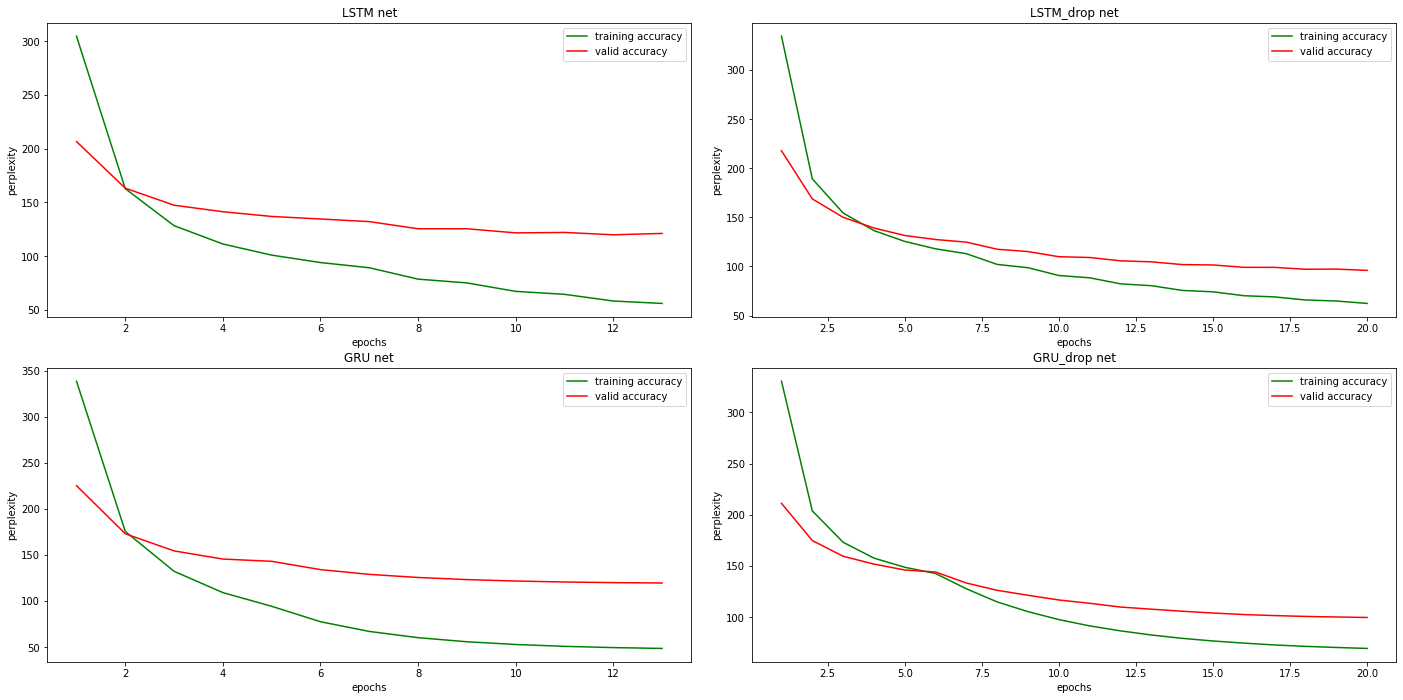

In [ ]:
run_save_display_all()

In [ ]:
run_all_presaved()

evaluating pre trained LSTM without drop:
Test Perplexity: 118.0842... Test loss: 4.7714...
evaluating pre trained LSTM with drop:
Test Perplexity: 92.7155... Test loss: 4.5295...
evaluating pre trained GRU without drop:
Test Perplexity: 116.5346... Test loss: 4.7582...
evaluating pre trained GRU with drop:
Test Perplexity: 95.9117... Test loss: 4.5634...


#running specific models:

In [ ]:
#run this cell before running specific models
train_perp_dict = {'LSTM+Dropout':[], 'LSTM':[], 'GRU+Dropout':[], 'GRU':[]}
val_perp_dict = {'LSTM+Dropout':[], 'LSTM':[], 'GRU+Dropout':[], 'GRU':[]}

##**LSTM+Dropout:**
dropout = 0.25, lr = 1.3, weight_decay = 1e-5
momentum = 0.9, clip = 5, factor = 1.3,
shrink_every = 2, shrink_since = 7.

**result:** 

* Train Perplexity: 69.1756... Validation Perplexity: 97.0195...
* Test Perplexity: 94.0705... Test loss: 4.5440...


In [ ]:
lstm_drop_drop = 0.25
lstm_drop_lr = 1.3
lstm_drop_wd = 1e-5
lstm_drop_mom = 0.9
lstm_drop_clip = 5
lstm_drop_factor = 1.3
lstm_drop_se = 2
lstm_drop_ss = 7

In [ ]:
lstm_drop = Model(mode="LSTM", with_drop=True, drop=lstm_drop_drop, vocab_size=vocab_size).to(device)
optimizer = optim.SGD(lstm_drop.parameters(), lr=lstm_drop_lr, weight_decay=lstm_drop_wd, momentum = lstm_drop_mom)
lstm_drop, lstm_drop_train_perp, lstm_drop_val_perp = train_model(lstm_drop, nn.CrossEntropyLoss(), optimizer,
                                                                  lstm_drop.n_layers, lstm_drop.batch_size, train_t, valid_t,
                                                                  20, clip=lstm_drop_clip, factor=lstm_drop_factor,
                                                                  shrink_every=lstm_drop_se, shrink_since=lstm_drop_ss)



In [ ]:
evaluate_model(lstm_drop, test_t, nn.CrossEntropyLoss())

In [ ]:
save_model_with_checkpoint(lstm_drop, lstm_drop_lr)
train_perp_dict['LSTM+Dropout'] = lstm_drop_train_perp
val_perp_dict['LSTM+Dropout'] = lstm_drop_val_perp

##**LSTM:**
lr = 1.3, weight_decay = 1e-5 momentum = 0.9, clip = 5, factor = 1.3, shrink_every = 2, shrink_since = 7.

results: 
* Train Perplexity: 56.0069... Validation Perplexity: 121.5314...
* Test Perplexity: 117.8864... Test loss: 4.7697...

In [ ]:
lstm_lr = 1.3
lstm_wd = 1e-5
lstm_mom = 0.9
lstm_clip = 5
lstm_factor = 1.3
lstm_se = 2
lstm_ss = 7

In [ ]:
lstm = Model(mode="LSTM", with_drop=False, vocab_size=vocab_size).to(device)
optimizer = optim.SGD(lstm.parameters(), lr=lstm_lr, weight_decay=lstm_wd, momentum = lstm_mom)
lstm, lstm_train_perp, lstm_val_perp = train_model(lstm, nn.CrossEntropyLoss(), optimizer,
                                                                  lstm.n_layers, lstm.batch_size, train_t, valid_t,
                                                                  20, clip=lstm_clip, factor=lstm_factor,
                                                                  shrink_every=lstm_se, shrink_since=lstm_ss)


# adamLSTM = train_model_with_loaders(adamLSTM, nn.CrossEntropyLoss(), optimizer, adamLSTM.n_layers,
                      #  adamLSTM.batch_size, train_loader, valid_loader, 20, clip=2.5)

In [ ]:
evaluate_model(lstm, test_t, criterion=nn.CrossEntropyLoss())

In [ ]:
save_model_with_checkpoint(lstm, lstm_lr)
train_perp_dict['LSTM'] = lstm_train_perp
val_perp_dict['LSTM'] = lstm_val_perp

##**GRU+Dropout:**

drop = 0.3, lr= 0.35, weight_decay = 1e-5 momentum = 0.95, clip = 5, factor = 1.25, shrink_every = 1, shrink_since = 7.

results: 
* Train Perplexity: 69.1082... Validation Perplexity: 99.4743...


* Test Perplexity: 95.8644... Test loss: 4.5629...




In [ ]:
gru_drop_drop = 0.3
gru_drop_lr = 0.35
gru_drop_wd = 1e-5
gru_drop_mom = 0.95
gru_drop_clip = 5
gru_drop_factor = 1.25
gru_drop_se = 1
gru_drop_ss = 7

In [ ]:
gru_drop = Model(mode="GRU", with_drop=True, drop=gru_drop_drop, vocab_size=vocab_size).to(device)
optimizer = optim.SGD(gru_drop.parameters(), lr=gru_drop_lr, weight_decay=gru_drop_wd, momentum = gru_drop_mom)
gru_drop, gru_drop_train_perp, gru_drop_val_perp = train_model(gru_drop, nn.CrossEntropyLoss(), optimizer,
                                                                  gru_drop.n_layers, gru_drop.batch_size, train_t, valid_t,
                                                                  20, clip=gru_drop_clip, factor=gru_drop_factor,
                                                                  shrink_every=gru_drop_se, shrink_since=gru_drop_ss)


# adamLSTM = train_model_with_loaders(adamLSTM, nn.CrossEntropyLoss(), optimizer, adamLSTM.n_layers,
                      #  adamLSTM.batch_size, train_loader, valid_loader, 20, clip=2.5)

In [ ]:
evaluate_model(gru_drop, test_t, criterion=nn.CrossEntropyLoss())

In [ ]:
# save_model_with_checkpoint(gru_drop, gru_drop_lr)
train_perp_dict['GRU+Dropout'] = gru_drop_train_perp
val_perp_dict['GRU+Dropout'] = gru_drop_val_perp

##**GRU:**


lr= 0.25, weight_decay = 1e-5 momentum = 0.9, clip = 5, factor = 1.5, shrink_every = 1, shrink_since = 6.

results: 
* Train Perplexity: 48.5318... Validation Perplexity: 119.8510...


* Test Perplexity: 116.7573... Test loss: 4.7601...



In [ ]:
gru_lr = 0.25
gru_wd = 1e-5
gru_mom = 0.9
gru_clip = 5
gru_factor = 1.5
gru_se = 1
gru_ss = 6

In [ ]:
gru = Model(mode="GRU", with_drop=False, vocab_size=vocab_size).to(device)
optimizer = optim.SGD(gru.parameters(), lr=gru_lr, weight_decay=gru_wd, momentum = gru_mom)
gru, gru_train_perp, gru_val_perp = train_model(gru, nn.CrossEntropyLoss(), optimizer,
                                                                  gru.n_layers, gru.batch_size, train_t, valid_t,
                                                                  20, clip=gru_clip, factor=gru_factor,
                                                                  shrink_every=gru_se, shrink_since=gru_ss)


# adamLSTM = train_model_with_loaders(adamLSTM, nn.CrossEntropyLoss(), optimizer, adamLSTM.n_layers,
                      #  adamLSTM.batch_size, train_loader, valid_loader, 20, clip=2.5)

In [ ]:
evaluate_model(gru, test_t, criterion=nn.CrossEntropyLoss())

In [ ]:
save_model_with_checkpoint(gru, gru_lr)
train_perp_dict['GRU'] = gru_train_perp
val_perp_dict['GRU'] = gru_val_perp

In [ ]:
display_graphs(train_perp_dict, val_perp_dict)

#Testing Loaded Models:

In [ ]:
lstm_loaded = load_model_from_mode("LSTM", False, 0.25, 1.3).to(device)
print(lstm_loaded.mode)
evaluate_model(lstm_loaded, test_t, nn.CrossEntropyLoss())